# Compute a simple FF with nlopt package

We will the simplest possible FF using nlopt to learn how the basics work. We will restrict us to the simplest case, using only the domminant modes (2,2) and (2,-2), moreover the only nonfixed parameter at first will be the masses of the black holes. 

### Import Useful packages

In [3]:
import math
import lal
import lalsimulation as lalsim
import numpy as np
import matplotlib.pyplot as plt 
import random as rnd
import nlopt

from pycbc.filter import match as simple_match, optimized_match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.waveform.utils import coalign_waveforms

/tmp/ipykernel_2509/2632167788.py:2: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


### Define the simulation function for nonspinning binary systems

In [4]:
def simulationTD_IMRPhenomTHM(mass1: float, mass2: float, r: float, delta_T: float, f_min: float, f_ref: float, spin1: tuple = (0, 0, 0),
                              spin2: tuple = (0, 0, 0), inclination: float = 0, phiRef: float = 0, eccentricity: float = 0) -> tuple:

    Approximant = "IMRPhenomTHM"

    (spin1x, spin1y, spin1z) = spin1
    (spin2x, spin2y, spin2z) = spin2

    # Modes
    mode_list = [[2, 2], [2, -2]]

    # Create the waveform parameters structure
    waveform_params = lal.CreateDict()

    mode_array = lalsim.SimInspiralCreateModeArray()
    for l, m in mode_list:
        lalsim.SimInspiralModeArrayActivateMode(mode_array, l, m)
    lalsim.SimInspiralWaveformParamsInsertModeArray(
        waveform_params, mode_array)

    with lal.no_swig_redirect_standard_output_error():
        # Generate the waveform
        hplus, hcross = lalsim.SimInspiralChooseTDWaveform(
            mass1, mass2, spin1x, spin1y, spin1z, spin2x, spin2y, spin2z, r, inclination, phiRef, 0.0, eccentricity, 0.0,
            delta_T, f_min, f_ref, waveform_params, lalsim.GetApproximantFromString(
                Approximant)
        )

    # Extract time series for both plus (h_plus) and cross (h_cross) polarizations
    h_plus = hplus.data.data
    h_cross = hcross.data.data
    time = np.arange(len(h_plus)) * delta_T

    # The data is returned as Numpy arrays, we lost information of the epoch, etc which we won't use in this example
    return h_plus, h_cross, time

### Define the match function

In [5]:
def perform_match(hnr, hap, f_lower, f_high, optimized = False, return_phase = False):
    FD = isinstance(hnr, FrequencySeries)
    if not FD: 
        hnr, hap = hnr.real(), hap.real()
    
    # Match signal sizes
    length = min(len(hnr), len(hap))
    hnr.resize(length); hap.resize(length)

    # Compute PSD
    if FD: 
        delta_f = hnr.delta_f
    else:
        delta_f = 1/hnr.duration
    
    psd = aLIGOZeroDetHighPower(length, delta_f, f_lower)
    
    # Compute Match
    match_kwargs = dict(vec1 = hnr, vec2 = hap, psd = psd, low_frequency_cutoff = f_lower, high_frequency_cutoff = f_high, return_phase = return_phase)
    return optimized_match(**match_kwargs) if optimized else simple_match(**match_kwargs, subsample_interpolation = True)

### Define and Simulate the target gravitational Wave

In [6]:
mass1_target = 30 * lal.MSUN_SI
mass2_target = 30 * lal.MSUN_SI
r_target = 1e6 * lal.PC_SI

delta_T = 1.0/4096.0 
f_min = 15
f_max = 250
f_ref = f_min

hp_target, hc_target, time_target = simulationTD_IMRPhenomTHM(mass1_target, mass2_target, r_target, delta_T, f_min, f_ref)

hp_target = TimeSeries(hp_target, delta_t=delta_T) 


### Define the function to optimize

We will optimize the match, but the nlopt package minimizes the function given. We want to maximize it, so our function have a minus sign at the end to take this into account. Moreover, we want to optimize a function which only receives the free parameters so the rest will be received as global constants. We also write explicitely grad so that the syntax of the package works. 

In [7]:
def opt_match(masses:list, grad): # masses = [m1, m2]

    mass1 = masses[0]
    mass2 = masses[1]

    hp, hc, time = simulationTD_IMRPhenomTHM(mass1, mass2, r_target, delta_T, f_min, f_ref) # Arreglar con global data

    hp = TimeSeries(hp, delta_t = delta_T) 

    match, _ = perform_match(hp_target, hp, f_lower = f_min, f_high = f_max, optimized = False, return_phase = False)

    return -match # EL negativo es porque nlopt minimiza funciones no las maximiza

In [8]:
def chirp_mass_function(masses:list):

    return ((masses[0]*masses[1])**(3/5))/((masses[0]+masses[1])**(1/5))

### Optimization

First of all, we give the program the function to optimize and define bounds of the parameters, then we set the tolerance of the solution and compute the optimization. Finally, we calculate the chirp mass an print the results. 

Lets start with the boundaries. The masses of the black holes must be positive and nonzero, $m>0$, so we would expect a lower bound of $m_1,m_2>0$. However, if the mass is too similar to zero the lalsimulation does not work. I have written 1*M_sol because of that. Altough tecnically, the most correct lower bound would be the Tolman–Oppenheimer–Volkoff limit of Black Holes. Then, why do we have to write a uppe bound? The simulation function assumes that the black holes have more or less the same masses, so it has a limit to the ratio between $m_1$ and $m_2$, this limit is $m_2/m_1>200$ or $m_1/m_2>200$. Because the program is written for stellar black holes and not supermassive Black holes it is limited to 199 solar masses.

Finally, there is two ways of defining the tolerance in this case. I have used th most typical one writting a tolerance over the parameters. However, because we know that the match should be near $match=1$ we can define a stop value of 1+errors (it is important to note that we write -1+èrrors, that is because nlopt minimizes the functions so we must take the minus sign into account). 

##### In this instance we optimize the match using the two masses as parameters

In [14]:
opt = nlopt.opt(nlopt.LN_NELDERMEAD, 2)
opt.set_lower_bounds([1*lal.MSUN_SI, 1*lal.MSUN_SI]) # Masses are positive. I have written 1*M_sol because writing 0 sometimes gives errors

opt.set_upper_bounds([199*lal.MSUN_SI, 199*lal.MSUN_SI]) # Masses are not too large (lalsim fails if m1/m2>200 or m2/m1>200)
 
opt.set_min_objective(opt_match)
# opt.set_xtol_rel(1e-4)
opt.set_stopval(-1+1e-4)


masses_initial = [20* lal.MSUN_SI, 15* lal.MSUN_SI]

masses = opt.optimize(masses_initial)
max_match = - opt.last_optimum_value()

chirp_mass_target = chirp_mass_function([mass1_target, mass2_target])
chirp_mass = chirp_mass_function(masses)

print(f"The chirp mass of these masses is {chirp_mass/lal.MSUN_SI}")
print(f"The chirp mass expected is {chirp_mass_target/lal.MSUN_SI}")

print(f"optimum at {masses[0]/lal.MSUN_SI}, {masses[1]/lal.MSUN_SI}")
print(f"maximum value = {max_match}")
print(f"result code = {opt.last_optimize_result()}")

The chirp mass of these masses is 26.103724867753186
The chirp mass expected is 26.116516898883617
optimum at 31.930975331084486, 28.18017104528553
maximum value = 0.999913600776416
result code = 2


#### In this instance we use the total mass and the chirp mass as the parameters to optimize

In [9]:
def params_to_masses(total_mass, chirp_mass):

    mass1 = (total_mass+math.sqrt(math.pow(total_mass,2)-4*math.pow(total_mass*math.pow(chirp_mass,5),1/3)))/2
    mass2 = (total_mass-math.sqrt(math.pow(total_mass,2)-4*math.pow(total_mass*math.pow(chirp_mass,5),1/3)))/2
    
    return mass1, mass2

In [17]:
def opt_match_params(params:list, grad): # masses = [m1, m2]

    if (params[0]**2-4*(params[0]*params[1]**5)**(1/3))<0:
        return 0


    masses = params_to_masses(params[0], params[1])

    mass1 = masses[0]
    mass2 = masses[1]

    hp, hc, time = simulationTD_IMRPhenomTHM(mass1, mass2, r_target, delta_T, f_min, f_ref) # Arreglar con global data

    hp = TimeSeries(hp, delta_t = delta_T) 

    match, _ = perform_match(hp_target, hp, f_lower = f_min, f_high = f_max, optimized = False, return_phase = False)
    return -match # EL negativo es porque nlopt minimiza funciones no las maximiza

In [18]:
opt = nlopt.opt(nlopt.LN_NELDERMEAD, 2)
opt.set_lower_bounds([2*lal.MSUN_SI, 1*lal.MSUN_SI]) # Masses are positive. I have written 1*M_sol because writing 0 sometimes gives errors

opt.set_upper_bounds([398*lal.MSUN_SI, 170*lal.MSUN_SI]) # Masses are not too large (lalsim fails if m1/m2>200 or m2/m1>200)
 
opt.set_min_objective(opt_match_params)
# opt.set_xtol_rel(1e-4)
opt.set_stopval(-1+1e-4)


masses_initial = [20* lal.MSUN_SI, 15* lal.MSUN_SI]
params_initial = [(masses_initial[0]+masses_initial[1]), chirp_mass_function(masses_initial)]

params = opt.optimize(params_initial)
max_match = - opt.last_optimum_value()

chirp_mass_target = chirp_mass_function([mass1_target, mass2_target])
chirp_mass = params[1]

print(f"maximum value = {max_match}")
print(f"result code = {opt.last_optimize_result()}")

print(f"The chirp mass of these masses is {chirp_mass/lal.MSUN_SI}")
print(f"The chirp mass expected is {chirp_mass_target/lal.MSUN_SI}")
print(f"The total mass of these masses is {params[0]/lal.MSUN_SI}")
print(f"The total mass expected is {(mass1_target+mass2_target)/lal.MSUN_SI}")

masses = params_to_masses(params[0], params[1])

print(f"optimum at {masses[0]/lal.MSUN_SI}, {masses[1]/lal.MSUN_SI}")


mal
mal
mal
mal
mal
mal
mal
maximum value = 0.9999955218737384
result code = 2
The chirp mass of these masses is 26.114459527638065
The chirp mass expected is 26.116516898883617
The total mass of these masses is 60.01314853594518
The total mass expected is 60.0
optimum at 30.67510392142259, 29.338044614522587


### Randomizing the starting value

In this cell, we randomize the starting masses instead of choosing one manually. We also make many optimizations so that we take the best one and we do not end up in a local maximum.

In [36]:
opt = nlopt.opt(nlopt.LN_NELDERMEAD, 2)
opt.set_lower_bounds([1*lal.MSUN_SI, 1*lal.MSUN_SI]) # Masses are positive (Explication above)
opt.set_upper_bounds([199*lal.MSUN_SI, 199*lal.MSUN_SI]) # Masses are not too large (lalsim fails if m1/m2>200 or m2/m1>200)

opt.set_min_objective(opt_match)
opt.set_xtol_rel(1e-4)
# opt.set_stopval(-1+1e-4)

match_final = 0
masses_final = []
for i in range(5):

    masses_initial=[rnd.randint(1,199)* lal.MSUN_SI, rnd.randint(5,100)* lal.MSUN_SI]
    print({masses_initial[0]/lal.MSUN_SI}, {masses_initial[1]/lal.MSUN_SI})
    masses = opt.optimize(masses_initial)
    max_match = - opt.last_optimum_value()

    if max_match > match_final:
        match_final = max_match
        masses_final = masses
        result_code = opt.last_optimize_result()
        masses_initial_print = masses_initial



chirp_mass_target = ((mass1_target*mass2_target)**(3/5))/((mass1_target+mass2_target)**(1/5))
chirp_mass = ((masses_final[0]*masses_final[1])**(3/5))/((masses_final[0]+masses_final[1])**(1/5))
print(f"The chirp mass of these masses is {chirp_mass/lal.MSUN_SI}")
print(f"The chirp mass expected is {chirp_mass_target/lal.MSUN_SI}")

print(f"optimum at {masses_final[0]/lal.MSUN_SI}, {masses_final[1]/lal.MSUN_SI}")
print(f"the initial masses were {masses_initial_print[0]/lal.MSUN_SI}, {masses_initial_print[1]/lal.MSUN_SI}")
print(f"maximum value = {match_final}")
print(f"result code = {result_code}")

{65.0} {68.0}
{66.0} {75.0}
{111.0} {58.0}
{9.0} {42.99999999999999}
{57.0} {12.0}
The chirp mass of these masses is 26.116473799798516
The chirp mass expected is 26.116516898883617
optimum at 30.106729193251294, 29.893625919562915
the initial masses were 57.0, 12.0
maximum value = 0.9999999990751529
result code = 4


## Plotting the Evolution of 5 initial random masses

Plotting the evolution of five initial random masses we can see how they move around and compare with the plot in Simple_FF.ipynb to see the maximums of the match.

In [112]:
def opt_match_saving_data(masses:list, grad): # masses = [m1, m2]

    mass1 = masses[0]
    mass2 = masses[1]

    hp, hc, time = simulationTD_IMRPhenomTHM(mass1, mass2, r_target, delta_T, f_min, f_ref) # Arreglar con global data

    hp = TimeSeries(hp, delta_t = delta_T) 

    match, _ = perform_match(hp_target, hp, f_lower = f_min, f_high = f_max, optimized = False, return_phase = False)

    Data.append([float(match), float(mass1/lal.MSUN_SI), float(mass2/lal.MSUN_SI)])

    return -match # EL negativo es porque nlopt minimiza funciones no las maximiza

In [140]:
Data = []

opt = nlopt.opt(nlopt.LN_NELDERMEAD, 2)
opt.set_lower_bounds([1*lal.MSUN_SI, 1*lal.MSUN_SI]) # Masses are positive (Explication above)
opt.set_upper_bounds([199*lal.MSUN_SI, 199*lal.MSUN_SI]) # Masses are not too large (lalsim fails if m1/m2>200 or m2/m1>200)

opt.set_min_objective(opt_match_saving_data)
opt.set_xtol_rel(1e-4)
# opt.set_stopval(-1+1e-4)

match_final = 0
masses_final = []
chirp_mass_initial_data = []
for i in range(5):

    masses_initial=[rnd.randint(1,199)* lal.MSUN_SI, rnd.randint(5,100)* lal.MSUN_SI]
    print({masses_initial[0]/lal.MSUN_SI}, {masses_initial[1]/lal.MSUN_SI})

    Data.append(["Initial", masses_initial[0]/lal.MSUN_SI, masses_initial[1]/lal.MSUN_SI])
    chirp_mass_initial_data.append(chirp_mass_function(masses_initial)/lal.MSUN_SI)

    masses = opt.optimize(masses_initial)
    max_match = - opt.last_optimum_value()

    if max_match > match_final:
        match_final = max_match
        masses_final = masses
        result_code = opt.last_optimize_result()
        masses_initial_print = masses_initial



chirp_mass_target = ((mass1_target*mass2_target)**(3/5))/((mass1_target+mass2_target)**(1/5))
chirp_mass = ((masses_final[0]*masses_final[1])**(3/5))/((masses_final[0]+masses_final[1])**(1/5))
print(f"The chirp mass of these masses is {chirp_mass/lal.MSUN_SI}")
print(f"The chirp mass expected is {chirp_mass_target/lal.MSUN_SI}")

print(f"optimum at {masses_final[0]/lal.MSUN_SI}, {masses_final[1]/lal.MSUN_SI}")
print(f"the initial masses were {masses_initial_print[0]/lal.MSUN_SI}, {masses_initial_print[1]/lal.MSUN_SI}")
print(f"maximum value = {match_final}")
print(f"result code = {result_code}")

{47.0} {75.0}
{85.99999999999999} {61.0}
{160.0} {40.0}
{154.0} {24.0}
{13.0} {90.0}
The chirp mass of these masses is 26.1164232551701
The chirp mass expected is 26.116516898883617
optimum at 30.16014032828952, 29.840665170798864
the initial masses were 85.99999999999999, 61.0
maximum value = 0.9999999956545182
result code = 4


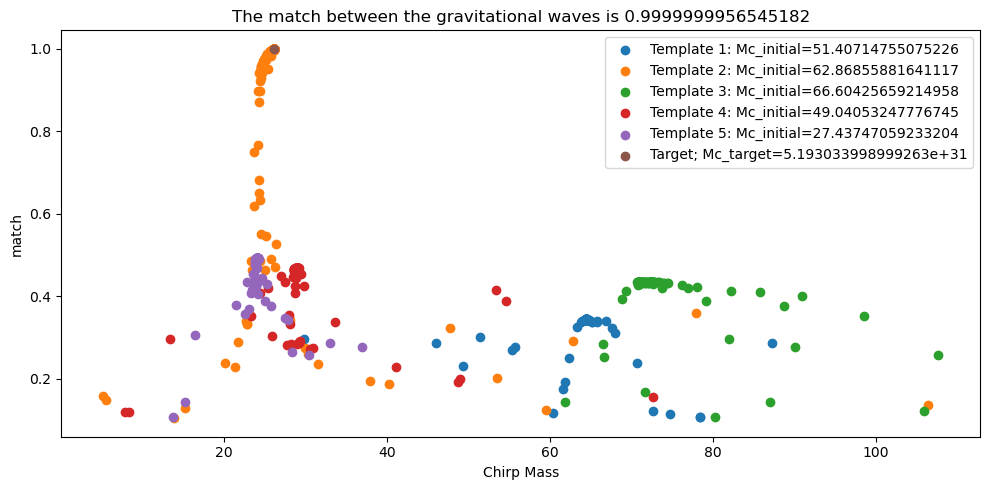

In [141]:
plot1_match = []
plot1_mass1 = []
plot1_mass2 = []
plot2_match = []
plot2_mass1 = []
plot2_mass2 = []
plot3_match = []
plot3_mass1 = []
plot3_mass2 = []
plot4_match = []
plot4_mass1 = []
plot4_mass2 = []
plot5_match = []
plot5_mass1 = []
plot5_mass2 = []
plot1_chirpmass=[] 
plot2_chirpmass=[]
plot3_chirpmass=[]
plot4_chirpmass=[]
plot5_chirpmass=[]
n=0
for match, mass1, mass2 in Data:
    if match == "Initial":
        n+=1
    
    elif n==1:
        plot1_match.append(match)
        plot1_mass1.append(mass1)
        plot1_mass2.append(mass2)
        plot1_chirpmass.append(chirp_mass_function([mass1,mass2])) 
    elif n==2:
        plot2_match.append(match)
        plot2_mass1.append(mass1)
        plot2_mass2.append(mass2)
        plot2_chirpmass.append(chirp_mass_function([mass1,mass2])) 
    elif n==3:
        plot3_match.append(match)
        plot3_mass1.append(mass1)
        plot3_mass2.append(mass2)
        plot3_chirpmass.append(chirp_mass_function([mass1,mass2])) 
    elif n==4:
        plot4_match.append(match)
        plot4_mass1.append(mass1)
        plot4_mass2.append(mass2)
        plot4_chirpmass.append(chirp_mass_function([mass1,mass2])) 
    elif n==5:
        plot5_match.append(match)
        plot5_mass1.append(mass1)
        plot5_mass2.append(mass2)
        plot5_chirpmass.append(chirp_mass_function([mass1,mass2])) 

plt.figure(figsize=(10,5))
plt.scatter(plot1_chirpmass,plot1_match, label = f'Template 1')
plt.scatter(plot2_chirpmass,plot2_match, label = f'Template 2')
plt.scatter(plot3_chirpmass,plot3_match, label = f'Template 3')
plt.scatter(plot4_chirpmass,plot4_match, label = f'Template 4')
plt.scatter(plot5_chirpmass,plot5_match, label = f'Template 5')
plt.scatter(chirp_mass_target/lal.MSUN_SI, 1, label = f'Target')
plt.title(f'The match between the gravitational waves is {match_final}')
plt.xlabel('Chirp Mass')
plt.ylabel('match')
plt.legend([f"Template 1: Mc_initial={chirp_mass_initial_data[0]}",f"Template 2: Mc_initial={chirp_mass_initial_data[1]}",f"Template 3: Mc_initial={chirp_mass_initial_data[2]}"
            ,f"Template 4: Mc_initial={chirp_mass_initial_data[3]}",f"Template 5: Mc_initial={chirp_mass_initial_data[4]}",f"Target; Mc_target={chirp_mass_target}"])

plt.tight_layout()
plt.show()
       

# Gradient-based algorithms

### Define the derivatives

We will define three different derivatives. First using the symmetrical formula (errors of $O(h^2)$)

$$

f'(x)\approx\frac{f(x+h)-f(x-h)}{2h}.

$$

And then using the Richardson formula (errors of $O(h^4)$)

$$

f'(x)\approx-\frac{1}{6h}\left(f(x+h)-8f\left(x+\frac{h}{2}\right)-f(x-h)+8f\left(x-\frac{h}{2}\right)\right)

$$

In [8]:
def sym_derivative_match(masses:list, n_mass:int, h):

    mass1 = masses[0]
    mass2 = masses[1]

    if n_mass == 0:

        hp_1, hc, time = simulationTD_IMRPhenomTHM(mass1+h, mass2, r_target, delta_T, f_min, f_ref) 
        hp_1 = TimeSeries(hp_1, delta_t = delta_T) 
        hp_2, hc, time = simulationTD_IMRPhenomTHM(mass1-h, mass2, r_target, delta_T, f_min, f_ref) 
        hp_2 = TimeSeries(hp_2, delta_t = delta_T) 

    elif n_mass == 1:

        hp_1, hc, time = simulationTD_IMRPhenomTHM(mass1, mass2+h, r_target, delta_T, f_min, f_ref) 
        hp_1 = TimeSeries(hp_1, delta_t = delta_T) 
        hp_2, hc, time = simulationTD_IMRPhenomTHM(mass1, mass2-h, r_target, delta_T, f_min, f_ref) 
        hp_2 = TimeSeries(hp_2, delta_t = delta_T)  

    else: print("Algo se ha liao")

    match_1,_ = perform_match(hp_target, hp_1, f_lower = f_min, f_high = f_max, optimized = False, return_phase = False)
    match_2,_ = perform_match(hp_target, hp_2, f_lower = f_min, f_high = f_max, optimized = False, return_phase = False)

    return (match_1-match_2)/2*h


def Richardson_derivative_match(masses:list, n_mass:int, h):

    mass1 = masses[0]
    mass2 = masses[1]

    if n_mass == 0:

        hp_1, hc, time = simulationTD_IMRPhenomTHM(mass1+h, mass2, r_target, delta_T, f_min, f_ref) 
        hp_1 = TimeSeries(hp_1, delta_t = delta_T) 
        hp_2, hc, time = simulationTD_IMRPhenomTHM(mass1-h, mass2, r_target, delta_T, f_min, f_ref) 
        hp_2 = TimeSeries(hp_2, delta_t = delta_T) 
        hp_3, hc, time = simulationTD_IMRPhenomTHM(mass1+h/2, mass2, r_target, delta_T, f_min, f_ref) 
        hp_3 = TimeSeries(hp_3, delta_t = delta_T) 
        hp_4, hc, time = simulationTD_IMRPhenomTHM(mass1-h/2, mass2, r_target, delta_T, f_min, f_ref) 
        hp_4 = TimeSeries(hp_4, delta_t = delta_T) 

    elif n_mass == 1:

        hp_1, hc, time = simulationTD_IMRPhenomTHM(mass1, mass2+h, r_target, delta_T, f_min, f_ref) 
        hp_1 = TimeSeries(hp_1, delta_t = delta_T) 
        hp_2, hc, time = simulationTD_IMRPhenomTHM(mass1, mass2-h, r_target, delta_T, f_min, f_ref) 
        hp_2 = TimeSeries(hp_2, delta_t = delta_T) 
        hp_3, hc, time = simulationTD_IMRPhenomTHM(mass1, mass2+h/2, r_target, delta_T, f_min, f_ref) 
        hp_3 = TimeSeries(hp_3, delta_t = delta_T) 
        hp_4, hc, time = simulationTD_IMRPhenomTHM(mass1, mass2-h/2, r_target, delta_T, f_min, f_ref) 
        hp_4 = TimeSeries(hp_4, delta_t = delta_T) 

    else: print("Algo se ha liao")

    match_1,_ = perform_match(hp_target, hp_1, f_lower = f_min, f_high = f_max, optimized = False, return_phase = False)
    match_2,_ = perform_match(hp_target, hp_2, f_lower = f_min, f_high = f_max, optimized = False, return_phase = False)
    match_3,_ = perform_match(hp_target, hp_3, f_lower = f_min, f_high = f_max, optimized = False, return_phase = False)
    match_4,_ = perform_match(hp_target, hp_4, f_lower = f_min, f_high = f_max, optimized = False, return_phase = False)

    return (match_1-match_2-8*(match_3-match_4))/(-6*h)

### Define the function to optimize

In [154]:
def opt_match_grad(masses:list, grad): # masses = [m1, m2]

    h_mass = 0.05*lal.MSUN_SI#Paso para derivar en funcion de las masas

    mass1 = masses[0]
    mass2 = masses[1]

    hp, hc, time = simulationTD_IMRPhenomTHM(mass1, mass2, r_target, delta_T, f_min, f_ref) # Arreglar con global data
    hp = TimeSeries(hp, delta_t = delta_T) 

    match, _ = perform_match(hp_target, hp, f_lower = f_min, f_high = f_max, optimized = False, return_phase = False)

    if grad.size > 0:
        for i in range(len(masses)):
            grad[i] = - Richardson_derivative_match(masses, i, h_mass) # EL negativo es porque nlopt minimiza funciones no las maximiza

    return -match # EL negativo es porque nlopt minimiza funciones no las maximiza

### Optimization

In [172]:
opt = nlopt.opt(nlopt.LD_AUGLAG, 2) # De los que he probado AUGLAG es el que mejor va
opt.set_lower_bounds([1*lal.MSUN_SI, 1*lal.MSUN_SI]) # Masses are positive. I have written 1*M_sol because writing 0 sometimes gives errors

opt.set_upper_bounds([199*lal.MSUN_SI, 199*lal.MSUN_SI]) # Masses are not too large (lalsim fails if m1/m2>200 or m2/m1>200)
 
opt.set_min_objective(opt_match_grad)
opt.set_xtol_rel(1e-4)
# opt.set_stopval(-1+1e-4)


masses_initial=[12* lal.MSUN_SI, 57* lal.MSUN_SI]
masses = opt.optimize(masses_initial)
max_match = - opt.last_optimum_value()

chirp_mass_target = ((mass1_target*mass2_target)**(3/5))/((mass1_target+mass2_target)**(1/5))
chirp_mass = ((masses[0]*masses[1])**(3/5))/((masses[0]+masses[1])**(1/5))
print(f"The chirp mass of these masses is {chirp_mass/lal.MSUN_SI}")
print(f"The chirp mass expected is {chirp_mass_target/lal.MSUN_SI}")

print(f"optimum at {masses[0]/lal.MSUN_SI}, {masses[1]/lal.MSUN_SI}")
print(f"maximum value = {max_match}")
print(f"result code = {opt.last_optimize_result()}")

The chirp mass of these masses is 25.54696079448431
The chirp mass expected is 26.116516898883617
optimum at 16.3518010225728, 56.63435741275555
maximum value = 0.5951156949149984
result code = 3


## Plotting the Evolution of 5 initial random masses

Plotting the evolution of five initial random masses we can see how they move around and compare with the plot in Simple_FF.ipynb to see the maximums of the match.

In [176]:
def opt_match_saving_data_grad(masses:list, grad): # masses = [m1, m2]
    
    h_mass = 0.05*lal.MSUN_SI#Paso para derivar en funcion de las masas

    mass1 = masses[0]
    mass2 = masses[1]

    hp, hc, time = simulationTD_IMRPhenomTHM(mass1, mass2, r_target, delta_T, f_min, f_ref) # Arreglar con global data

    hp = TimeSeries(hp, delta_t = delta_T) 

    match, _ = perform_match(hp_target, hp, f_lower = f_min, f_high = f_max, optimized = False, return_phase = False)

    if grad.size > 0:
        for i in range(len(masses)):
            grad[i] = - Richardson_derivative_match(masses, i, h_mass) # EL negativo es porque nlopt minimiza funciones no las maximiza

    Data_grad.append([float(match), float(mass1/lal.MSUN_SI), float(mass2/lal.MSUN_SI)])

    return -match # EL negativo es porque nlopt minimiza funciones no las maximiza

In [180]:
Data_grad = []

opt = nlopt.opt(nlopt.LD_AUGLAG, 2)
opt.set_lower_bounds([1*lal.MSUN_SI, 1*lal.MSUN_SI]) # Masses are positive (Explication above)
opt.set_upper_bounds([199*lal.MSUN_SI, 199*lal.MSUN_SI]) # Masses are not too large (lalsim fails if m1/m2>200 or m2/m1>200)

opt.set_min_objective(opt_match_saving_data_grad)
opt.set_xtol_rel(1e-4)
# opt.set_stopval(-1+1e-4)

match_final = 0
masses_final = []
chirp_mass_initial_data = []
for i in range(5):

    masses_initial=[rnd.randint(1,199)* lal.MSUN_SI, rnd.randint(5,100)* lal.MSUN_SI]
    print({masses_initial[0]/lal.MSUN_SI}, {masses_initial[1]/lal.MSUN_SI})

    Data_grad.append(["Initial", masses_initial[0]/lal.MSUN_SI, masses_initial[1]/lal.MSUN_SI])
    chirp_mass_initial_data.append(chirp_mass_function(masses_initial)/lal.MSUN_SI)

    masses = opt.optimize(masses_initial)
    max_match = - opt.last_optimum_value()

    if max_match > match_final:
        match_final = max_match
        masses_final = masses
        result_code = opt.last_optimize_result()
        masses_initial_print = masses_initial



chirp_mass_target = ((mass1_target*mass2_target)**(3/5))/((mass1_target+mass2_target)**(1/5))
chirp_mass = ((masses_final[0]*masses_final[1])**(3/5))/((masses_final[0]+masses_final[1])**(1/5))
print(f"The chirp mass of these masses is {chirp_mass/lal.MSUN_SI}")
print(f"The chirp mass expected is {chirp_mass_target/lal.MSUN_SI}")

print(f"optimum at {masses_final[0]/lal.MSUN_SI}, {masses_final[1]/lal.MSUN_SI}")
print(f"the initial masses were {masses_initial_print[0]/lal.MSUN_SI}, {masses_initial_print[1]/lal.MSUN_SI}")
print(f"maximum value = {match_final}")
print(f"result code = {result_code}")

{75.0} {96.0}
{33.0} {18.0}
{75.0} {35.0}
{50.0} {81.0}
{95.0} {15.0}
The chirp mass of these masses is 26.103498494408722
The chirp mass expected is 26.116516898883617
optimum at 31.982136900885912, 28.135733867550197
the initial masses were 33.0, 18.0
maximum value = 0.999907531534227
result code = 3


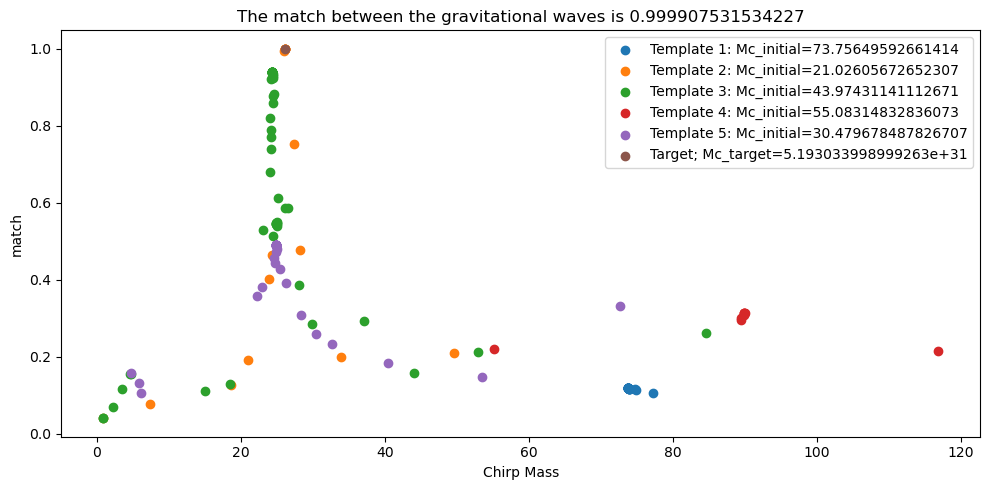

In [181]:
plot1_match = []
plot1_mass1 = []
plot1_mass2 = []
plot2_match = []
plot2_mass1 = []
plot2_mass2 = []
plot3_match = []
plot3_mass1 = []
plot3_mass2 = []
plot4_match = []
plot4_mass1 = []
plot4_mass2 = []
plot5_match = []
plot5_mass1 = []
plot5_mass2 = []
plot1_chirpmass=[] 
plot2_chirpmass=[]
plot3_chirpmass=[]
plot4_chirpmass=[]
plot5_chirpmass=[]
n=0
for match, mass1, mass2 in Data_grad:
    if match == "Initial":
        n+=1
    
    elif n==1:
        plot1_match.append(match)
        plot1_mass1.append(mass1)
        plot1_mass2.append(mass2)
        plot1_chirpmass.append(chirp_mass_function([mass1,mass2])) 
    elif n==2:
        plot2_match.append(match)
        plot2_mass1.append(mass1)
        plot2_mass2.append(mass2)
        plot2_chirpmass.append(chirp_mass_function([mass1,mass2])) 
    elif n==3:
        plot3_match.append(match)
        plot3_mass1.append(mass1)
        plot3_mass2.append(mass2)
        plot3_chirpmass.append(chirp_mass_function([mass1,mass2])) 
    elif n==4:
        plot4_match.append(match)
        plot4_mass1.append(mass1)
        plot4_mass2.append(mass2)
        plot4_chirpmass.append(chirp_mass_function([mass1,mass2])) 
    elif n==5:
        plot5_match.append(match)
        plot5_mass1.append(mass1)
        plot5_mass2.append(mass2)
        plot5_chirpmass.append(chirp_mass_function([mass1,mass2])) 

plt.figure(figsize=(10,5))
plt.scatter(plot1_chirpmass,plot1_match, label = f'Template 1')
plt.scatter(plot2_chirpmass,plot2_match, label = f'Template 2')
plt.scatter(plot3_chirpmass,plot3_match, label = f'Template 3')
plt.scatter(plot4_chirpmass,plot4_match, label = f'Template 4')
plt.scatter(plot5_chirpmass,plot5_match, label = f'Template 5')
plt.scatter(chirp_mass_target/lal.MSUN_SI, 1, label = f'Target')
plt.title(f'The match between the gravitational waves is {match_final}')
plt.xlabel('Chirp Mass')
plt.ylabel('match')
plt.legend([f"Template 1: Mc_initial={chirp_mass_initial_data[0]}",f"Template 2: Mc_initial={chirp_mass_initial_data[1]}",f"Template 3: Mc_initial={chirp_mass_initial_data[2]}"
            ,f"Template 4: Mc_initial={chirp_mass_initial_data[3]}",f"Template 5: Mc_initial={chirp_mass_initial_data[4]}",f"Target; Mc_target={chirp_mass_target}"])

plt.tight_layout()
plt.show()
       

Ideas:

    - Introduce nonprecessing spins to the optimization
    - **IMPORTANT**: Change the optimization parameters to total mass and chirp mass, they are a better choice
    - **IMPORTANT**: CALCULAR LOS VALORES MAXIMOS Y MINIMOS DE LA CHIRP MASS PARA LOS BOUNDS